# Tweet Sentiment Analysis

**Objective -**

Sentiment analysis is a common use case of NLP where the idea is to classify the tweet as positive, negative or neutral depending upon the text in the tweet. This problem goes a way ahead and expects us to also determine the words in the tweet which decide the polarity of the tweet.

## Dataset and Dependencies

### Importing the necessary libraries

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow

In [ ]:
##### Importing Libraries
!pip install wordcloud
!pip install Unidecode
!pip install word2number
!pip install pycontractions
!pip install ktrain
!pip install transformers

import numpy as np 
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import string
from wordcloud import WordCloud ,  STOPWORDS
from bs4 import BeautifulSoup
import spacy
import unidecode
from word2number import w2n
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from transformers import BertTokenizer
from sklearn.model_selection import StratifiedKFold
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
import tensorflow as tf
from transformers import BertTokenizer
import torch
import torchvision
print('TF version',tf.__version__)

### Reading Dataset

In [ ]:
train = pd.read_csv("/content/drive/My Drive/Tweet Sentiment Analysis/train.csv")
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
test = pd.read_csv("/content/drive/My Drive/Tweet Sentiment Analysis/test.csv")
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [ ]:
submission = pd.read_csv("/content/drive/My Drive/Tweet Sentiment Analysis/sample_submission.csv")
submission.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


## Exploratory Data Analysis


*   Missing Values treatment in the dataset
*   Removing the rows in dataset



In [ ]:
### Droping the cols of "textID"
train.drop(["textID"] , axis = 1 , inplace = True)
train.head()

,text,selected_text,sentiment
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,my boss is bullying me...,bullying me,negative
3,what interview! leave me alone,leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
### Checking the values which are being null in any row
print(train.isnull().sum())
print(test.isnull().sum())
### Removing the rows which have null data in any col
train.dropna(axis = 0 , how = 'any' , inplace = True )
test.dropna(axis  = 0 , how = 'any' , inplace = True )

text             1
selected_text    1
sentiment        0
dtype: int64
textID       0
text         0
sentiment    0
dtype: int64


In [ ]:
###### Positive , Neagative and Neutral Tweet which is being there
print("Positive Tweet : " , train[train['sentiment'] == 'positive']['text'].values[0])
print("Negative Tweet : " , train[train['sentiment'] == 'negative']['text'].values[0])
print("Neutral Tweet : " , train[train['sentiment'] == 'neutral']['text'].values[0])

Positive Tweet :  2am feedings for the baby are fun when he is all smiles and coos
Negative Tweet :   Sooo SAD I will miss you here in San Diego!!!
Neutral Tweet :   I`d have responded, if I were going


In [ ]:
### Getting the percentage of the values of dataset of each category
train['sentiment'].value_counts(normalize = True)

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

In [ ]:
### Getting value counts of numbers of text of each category
dd = train['sentiment'].value_counts()
print(type(dd))
dd.head()

<class 'pandas.core.series.Series'>


neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

# Text Preprocessing 
Before we  start with any NLP dataset we need to pre-process the data to get it all in a consistent format. We need to clean , tokenize and covert our data into a matrix.

*   Make text lowercase
*   Remove Hyperlinks
*   Remove Punctuation
*   Remove Numbers
*   Tokenizes
*   Remove Stop-Words
*   Remove Stemming-Words eg- doing , does , do all to the form of do










In [ ]:
def remove_punctuation(s) :
  punctuations = "0123456789!()-[]{};:'\",<>./?@#$%^&*_~"
  no_punct = ""
  for char in s:
    if char not in punctuations:
      no_punct = no_punct + char
  return no_punct

def remove_hyperlink(s) : 
  s = re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE)
  return s

def strip_html_tags(text):
  """remove html tags from text"""
  soup = BeautifulSoup(text, "html.parser")
  stripped_text = soup.get_text(separator=" ")
  return stripped_text

def remove_accented_chars(text):
  """remove accented characters from text, e.g. café"""
  text = unidecode.unidecode(text)
  return text

def expand_contractions(text):
  """expand shortened words, e.g. don't to do not"""
  text = list(cont.expand_texts([text], precise=True))[0]
  return text

def convert_spelling_to_numbers(text) :
  doc = nlp(text)
  tokens = [w2n.word_to_num(token.text) if token.pos_ == 'NUM' else token for token in doc]
  text = " ".join(tokens)
  return text

def remove_stemming(text) :
  tokens = text.split()
  porter = PorterStemmer()
  stemmed = [porter.stem(word) for word in tokens]
  text = " ".join(stemmed)
  return text

def remove_stop_words(text) :
  text = text.split()
  cachedStopWords = stopwords.words("english")
  text = [x for x in text if x.isalpha()]
  text = [x for x in text if x not in cachedStopWords ]
  text = " ".join(text)
  return text

def numeric_type(s) :
  try :
    s = int(s)
    return True
  except :
    return False

def text_preprocessing(s) :
  s = s.lower()
  s = remove_hyperlink(s)
  s = remove_punctuation(s)
  s = strip_html_tags(s)
  s = remove_accented_chars(s)
  #s = expand_contractions(s)
  #s = convert_spelling_to_numbers(s)
  s = remove_stemming(s)
  s = remove_stop_words(s)
  s = s.split()
  s = [x for x in s if x is not numeric_type(x)]
  s = " ".join(s)
  return s



In [ ]:
#### Cleaning the text as per above methods
train['text_clean'] = train['text'].apply(str).apply(lambda x : text_preprocessing(x))
test['text_clean'] = test['text'].apply(str).apply(lambda x : text_preprocessing(x))
### Getting the length of clean text
train['text_len'] = train['text_clean'].astype(str).apply(len)
test['text_len'] = test['text_clean'].astype(str).apply(len)
### No. of words in the clean text 
train['word_cnt'] = train['text_clean'].astype(str).apply(lambda x : len(str(x).split()))
test['word_cnt'] = test['text_clean'].astype(str).apply(lambda x : len(str(x).split()))

In [ ]:
train.head()


,text,selected_text,sentiment,text_clean,text_len,word_cnt
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,respond go,10,2
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego,23,5
2,my boss is bullying me...,bullying me,negative,boss bulli,10,2
3,what interview! leave me alone,leave me alone,negative,interview leav alon,19,3
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son whi put releas alreadi bought,33,6


In [ ]:
pos = train[train['sentiment'] == 'positive']
neg = train[train['sentiment'] == 'negative']
neutral = train[train['sentiment'] == 'neutral']

# Analyzing Text Statistics
We will perform some statistical analysis to explore the fundamental characteristics of the text data.

*   Text length analysis
*   Word frequency analysis



## Histogram and Box Plot
The histogram shows that the length of the cleaned text ranges from around 2 to 140 characters and generally,it is almost same for all the polarities.

In [ ]:
fig = px.histogram(train , x  = 'word_cnt' , color = 'sentiment', title = "Word-Count Frequencies Sentiment Analysis")
fig.show()

In [ ]:
fig = px.box(train , x = 'sentiment' , y = 'word_cnt' , points = 'all' , title = "Box Plot for Length of Words" , 
             color = 'sentiment')
fig.show()

## Ngram Exploration
To analyse the text column we will be extracting the N-Gram features.

N-grams are used to describe the number of words used as observation points, e.g., unigram means singly-worded, bigram means 2-worded phrase, and trigram means 3-worded phrase. Here is a nice way to understand this:

![Ngrams Description](https://i.stack.imgur.com/8ARA1.png)
Source - Stack overflow


In [ ]:
def token_vectorize(df  , title = "No defiened" , min_df = 2 , max_df = 0.8 , ngrams_min = 1 , ngrams_max = 1  , color = 'blue' ) :
  cnt_vectorizer  = CountVectorizer(min_df = 2 , max_df = 0.8 ,ngram_range = (ngrams_min , ngrams_max) )
  cnt_vectorizer.fit(df['text_clean'])
  vectors = cnt_vectorizer.transform(df['text_clean'])
  vectors = vectors.toarray()
  vectors = vectors.sum(axis = 0 )
  frame = pd.DataFrame({"words" : cnt_vectorizer.get_feature_names() , "freq" : vectors })
  frame.sort_values(['freq'] , axis = 0 , ascending = False , inplace = True )
  fig = px.bar(frame.iloc[:100 , : ] , x = 'words' , y = 'freq', title = title , color_discrete_sequence=[color])
  fig.show()

In [ ]:
token_vectorize(pos , "Positive  Unigrams" , 2 , 0.8 , 1 ,1  , 'green')
token_vectorize(pos , "Positive  Bigrams" , 2 , 0.8 , 2 ,2 , 'green')

token_vectorize(neg , "Negative Unigrams" , 2 , 0.8 , 1 ,1 , 'red')
token_vectorize(neg , "Negative Bigrams" , 2 , 0.8 , 2 ,2 , 'red')

token_vectorize(neutral , "Neutral Unigrams" , 2 , 0.8, 1 ,1  )
token_vectorize(neutral , "Neutral Bigrams" , 2 , 0.8, 2 ,2 )


## Word Clouds 

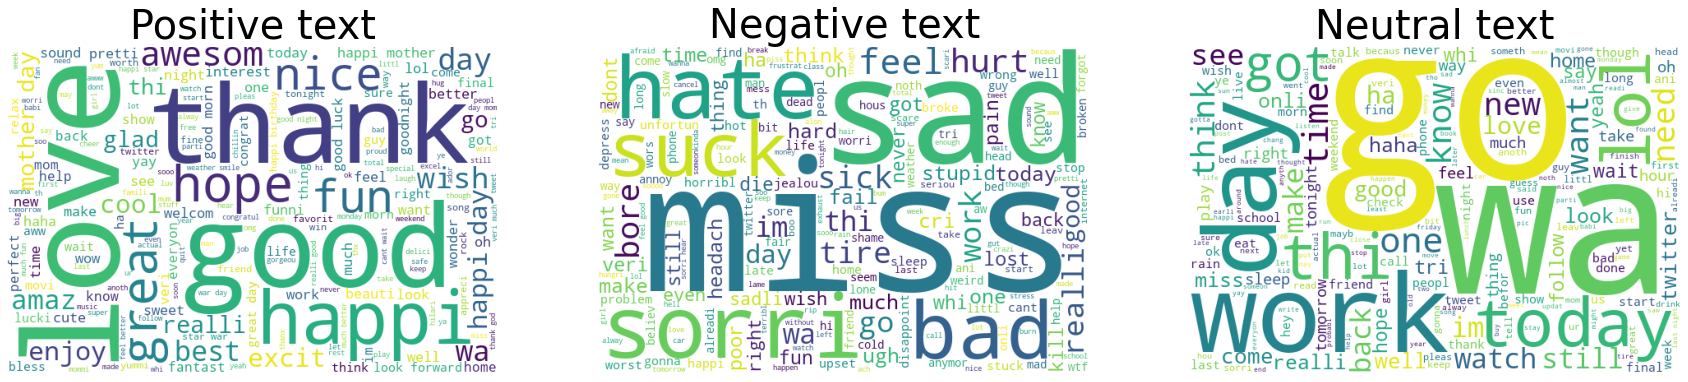

In [ ]:
positive_text = train[train['sentiment'] == 'positive']['selected_text']
negative_text = train[train['sentiment'] == 'negative']['selected_text']
neutral_text = train[train['sentiment'] == 'neutral']['selected_text']

positive_text_clean = positive_text.apply(lambda x: text_preprocessing(x))
negative_text_clean = negative_text.apply(lambda x: text_preprocessing(x))
neutral_text_clean = neutral_text.apply(lambda x: text_preprocessing(x))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_text_clean))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive text',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_text_clean))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative text',fontsize=40);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neutral_text_clean))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral text',fontsize=40);


# Generating Models for Text Classification

## Data Preparation

In [ ]:
train.head()

,text,selected_text,sentiment,text_clean,text_len,word_cnt
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,respond go,10,2
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego,23,5
2,my boss is bullying me...,bullying me,negative,boss bulli,10,2
3,what interview! leave me alone,leave me alone,negative,interview leav alon,19,3
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son whi put releas alreadi bought,33,6


In [ ]:
### Combining the data of train and test data completely
X = np.concatenate([train.text_clean.values , test.text_clean.values])
Y = np.concatenate([train.sentiment.values , test.sentiment.values])
print("X shape : " , X.shape)
print("Y shape : " , Y.shape)
### Converting the values to Label Encoders
le = LabelEncoder()
YLabelEncoder = le.fit_transform(Y)
YLabelEncoder = YLabelEncoder.reshape(-1 , 1)
print("YLabelEncoder shape : " , YLabelEncoder.shape)
### Converting the values of Label Encoders to ONE HOT
onehotencoder = OneHotEncoder()
YOneHot = onehotencoder.fit_transform(YLabelEncoder).toarray()
print("YOneHot shape : " , YOneHot.shape)

X shape :  (31014,)
Y shape :  (31014,)
YLabelEncoder shape :  (31014, 1)
YOneHot shape :  (31014, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



## Converting the Words to Tokens IDs

In [ ]:
max_words = 5000
max_len = 25
EMBEDDING_DIM = 250
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
XMatrix = sequence.pad_sequences(sequences,maxlen=max_len , padding = 'post') 
print(tok)
print(sequences)
print(XMatrix)

[[1223, 2], [320, 52, 18, 1125, 1838], [1099, 3929], [834, 155, 392], [648, 55, 194, 894, 131, 447], [], [1126, 188, 47, 508], [448, 433], [], [1839, 183, 20, 2195, 3068, 413, 724], [37, 8, 28, 2773, 525, 4653, 95, 66, 3, 509, 219], [22, 22, 9, 145, 8, 554, 944, 2059], [203, 2353, 814, 4654], [16, 2, 224, 62, 218, 877], [380, 380, 3930], [1442, 38, 1009], [53, 2774, 2531, 878, 474], [114, 510, 1, 2775, 227, 32, 4655, 304, 1355, 49, 32], [21, 31, 66, 18, 288, 13], [], [38, 59, 28, 124, 104], [88, 1577, 358, 22, 408, 30, 294, 1396, 1224, 179, 57, 3069, 1396], [272, 141, 241, 2196, 193, 11], [234, 4656, 364, 144, 329, 4, 370, 194, 201, 2197], [23, 784, 161, 482, 96, 623, 147, 1309], [300, 561, 511, 47, 26, 879], [59], [71, 346, 916, 835], [2532, 344, 180, 4657, 47, 680, 310], [158, 58, 760, 442, 760, 21, 7], [2, 31, 305, 30, 46, 797], [28, 4658, 29, 1658, 659, 4658], [107, 3931, 10, 380, 317, 56, 35, 37, 2198, 310], [64, 273, 271, 199], [660, 640, 212, 66, 53, 92, 39, 50, 70, 28, 88, 2060

## Spliting the Dataset

In [ ]:
#### Y is in format of One Hot Encoder
X_train, X_test, Y_train, Y_test = train_test_split(XMatrix,YOneHot, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(26361, 25) (26361, 3)
(4653, 25) (4653, 3)


## Making Neural Network Model

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,150,input_length=max_len , trainable = True)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(3,name='out_layer' , activation = 'softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

def RNN1():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,250,input_length=max_len , trainable = True)(inputs)
    layer = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(3,name='out_layer' , activation = 'softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

def RNNBertBaseUncased() :
  MODEL_NAME = 'bert_base_uncased'
  t = text.Transformer(MODEL_NAME, maxlen=500,  
                     classes=train_b.target_names)
  trn = t.preprocess_train(x_train, y_train)
  val = t.preprocess_test(x_test, y_test)
  model = t.get_classifier()
  return model


def predictScore(model , model_name , X_test , Y_test) :
  Y_predict = model.predict(x= X_test, batch_size=32, verbose=1)
  test_accuracy = 0
  for i in range(len(X_test)):
    if (np.argmax(Y_predict[i]) == np.argmax(Y_test[i])):
        test_accuracy += 1
  test_accuracy = test_accuracy / len(X_test)*100
  print("Test Accuracy: " + model_name , test_accuracy)

def plotModelAccuracy(modelHistory , plotName) :
  plt.plot(modelHistory.history['accuracy'])
  plt.plot(modelHistory.history['val_accuracy'])
  plt.title(plotName +' : Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def plotModelLoss(modelHistory , plotName ) :
  plt.plot(modelHistory.history['loss'])
  plt.plot(modelHistory.history['val_loss'])
  plt.title(plotName + ' : model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 25)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 25, 150)           750000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                55040     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 3)                 771 

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 21088 samples, validate on 5273 samples
Epoch 1/30
21088/21088 [==============================] - 18s 839us/step - loss: 0.6077 - accuracy: 0.6767 - val_loss: 0.5167 - val_accuracy: 0.7363
Epoch 2/30
21088/21088 [==============================] - 17s 822us/step - loss: 0.4474 - accuracy: 0.7922 - val_loss: 0.4350 - val_accuracy: 0.8071
Epoch 3/30
21088/21088 [==============================] - 16s 782us/step - loss: 0.3816 - accuracy: 0.8376 - val_loss: 0.4385 - val_accuracy: 0.8086
Epoch 4/30
21088/21088 [==============================] - 17s 794us/step - loss: 0.3446 - accuracy: 0.8559 - val_loss: 0.4447 - val_accuracy: 0.8069
Epoch 5/30
21088/21088 [==============================] - 16s 781us/step - loss: 0.3157 - accuracy: 0.8699 - val_loss: 0.4639 - val_accuracy: 0.8045
Epoch 6/30
21088/21088 [==============================] - 17s 797us/step - loss: 0.2913 - accuracy: 0.8813 - val_loss: 0.5034 - val_accuracy: 0.7999
Epoch 7/30
21088/21088 [==============================] -

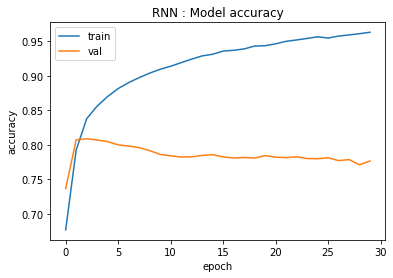

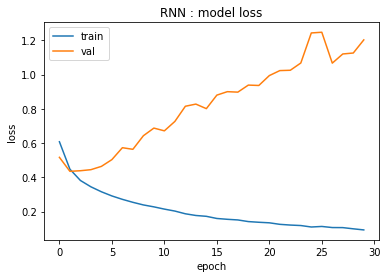

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer = 'adam' ,metrics=['accuracy'])
modelHistory = model.fit(X_train,Y_train,batch_size=128,epochs=30,
          validation_split=0.2 )

predictScore(model , "RNN" , X_test , Y_test)
plotModelAccuracy(modelHistory , "RNN")
plotModelLoss(modelHistory  , "RNN")


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 25)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 25, 150)           750000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                55040     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 3)                 771 

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 21088 samples, validate on 5273 samples
Epoch 1/30
21088/21088 [==============================] - 30s 1ms/step - loss: 0.6142 - accuracy: 0.6784 - val_loss: 0.5474 - val_accuracy: 0.7065
Epoch 2/30
21088/21088 [==============================] - 27s 1ms/step - loss: 0.4765 - accuracy: 0.7814 - val_loss: 0.4462 - val_accuracy: 0.8069
Epoch 3/30
21088/21088 [==============================] - 28s 1ms/step - loss: 0.4068 - accuracy: 0.8313 - val_loss: 0.4307 - val_accuracy: 0.8097
Epoch 4/30
21088/21088 [==============================] - 27s 1ms/step - loss: 0.3743 - accuracy: 0.8481 - val_loss: 0.4350 - val_accuracy: 0.8093
Epoch 5/30
21088/21088 [==============================] - 27s 1ms/step - loss: 0.3511 - accuracy: 0.8592 - val_loss: 0.4555 - val_accuracy: 0.8071
Epoch 6/30
21088/21088 [==============================] - 27s 1ms/step - loss: 0.3301 - accuracy: 0.8715 - val_loss: 0.4658 - val_accuracy: 0.8039
Epoch 7/30
21088/21088 [==============================] - 27s 1ms/ste

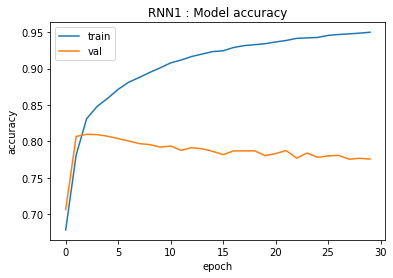

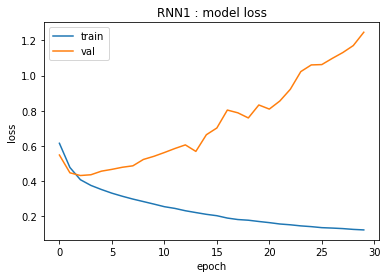

In [ ]:
model1 = RNN1() 
model.summary()
model1.compile(loss='binary_crossentropy',optimizer = 'adam' ,metrics=['accuracy'])
modelHistory1 = model1.fit(X_train,Y_train,batch_size=128,epochs=30,
          validation_split=0.2 )

predictScore(model1 , "RNN1" , X_test , Y_test)
plotModelAccuracy(modelHistory1 , "RNN1")
plotModelLoss(modelHistory1  , "RNN1")

## Supervised Machine Learning Alogrithms

In [ ]:
### Y is in format of Label Encoder
X_train, X_test, Y_train, Y_test = train_test_split(XMatrix,YLabelEncoder, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(26361, 25) (26361, 1)
(4653, 25) (4653, 1)


### MultiNomial Navie Bayes

In [ ]:
multinomialNB = MultinomialNB()
multinomialNB.fit(X_train , Y_train.flatten())
print("MulitNomial Navie Bayes : " ,multinomialNB.score(X_test , Y_test.flatten()))

MulitNomial Navie Bayes :  0.3913604126370084


In [ ]:
### Navie Bayie Using Count Vectorizer , TFidfTransformer , MultinomialNB
mnb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
mnb.fit(train.text_clean, train.sentiment)

y_pred = mnb.predict(test.text_clean)
print('MulitNomial Navie Bayes (Count Vectorizer , TFidfTransformer , MultinomialNB) \nAccuracy %s' % accuracy_score(y_pred, test.sentiment))

TypeError: ignored

### Logistic Regression


In [ ]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(train.text_clean, train.sentiment)
yPredict = logreg.predict(test.text_clean)

print('Logistic Regression :\nAccuracy %s' % accuracy_score(yPredict, test.sentiment))

### Support Vector Classification

In [ ]:
svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('svc', SVC(kernel='sigmoid', gamma=1.0))
               ])
svc.fit(train.text_clean, train.sentiment)
yPredict = svc.predict(test.text_clean)
print('SVC :\nAccuracy %s' % accuracy_score(yPredict, test.sentiment))

TypeError: ignored

#Enabling and testing the TPU
First, you'll need to enable TPUs for the notebook:

Navigate to Edit→Notebook Settings
select TPU from the Hardware Accelerator drop-down
Next, we'll check that we can connect to the TPU:

In [ ]:
%tensorflow_version 2.x
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.1.0


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  ['10.86.197.58:8470']
INFO:tensorflow:Initializing the TPU system: 10.86.197.58:8470


INFO:tensorflow:Initializing the TPU system: 10.86.197.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Tokenization

Here we are going to use the token from pretrained BertTokenizer

In [ ]:
MAX_LEN = 150  ### Max Lenght of the  Text 
PATH = '../input/tf-roberta/'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
train = pd.read_csv('/content/drive/My Drive/Tweet Sentiment Analysis/train.csv').fillna('')
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


## Preprocessing Data for Bert
BERT expects input data in a specific format i.e
*   Tokenized dataset
*   All the vectors should be of the same size.Hence,we need to pad the text to achieve a common length.This length will be decided by the length of longest sentence, which we will have to calculate.Also, since we shall concatanate the text and the sentiment column, the length should be decided by the concatanated text column.
*   We need to then differentiate between the Actual tokens and the Padded ones with the help of "Attention Masks".

[Hugging Face Documentation](https://huggingface.co/transformers/glossary.html#attention-mask)

The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the BertTokenizer, 1 indicate a value that should be attended to while 0 indicate a padded value.

Adding special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP]).





In [ ]:
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
    #print(enc)
      
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc)+5] = [0] + enc + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1
    

In [ ]:
test = pd.read_csv('/content/drive/My Drive/Tweet Sentiment Analysis/test.csv').fillna('')

ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc)+5] = [0] + enc + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc)+5] = 1

## Building Model Using bert_model

In [ ]:
MAX_LEN = 150
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig()
    bert_model = TFRobertaModel(config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(128, 2,padding='same')(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Conv1D(64, 2,padding='same')(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(128, 2, padding='same')(x2)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.Conv1D(64, 2, padding='same')(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    return model

def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

## Training model using TPU

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
  oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
  oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
  preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
  preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))


  skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
  for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

      print('#'*25)
      print('### FOLD %i'%(fold+1))
      print('#'*25)
      
      K.clear_session()
      model = build_model()
          
      sv = tf.keras.callbacks.ModelCheckpoint(
          '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
          save_weights_only=True, mode='auto', save_freq='epoch')
      
          
      model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
          epochs=3, batch_size=32, verbose=DISPLAY, callbacks=[sv],
          validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
          [start_tokens[idxV,], end_tokens[idxV,]]))
      
      print('Loading model...')
      model.load_weights('%s-roberta-%i.h5'%(VER,fold))
      
      print('Predicting OOF...')
      oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
      
      print('Predicting Test...')
      preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
      preds_start += preds[0]/skf.n_splits
      preds_end += preds[1]/skf.n_splits
      
      # DISPLAY FOLD JACCARD
      all = []
      for k in idxV:
          a = np.argmax(oof_start[k,])
          b = np.argmax(oof_end[k,])
          if a>b: 
              st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
          else:
              text1 = " "+" ".join(train.loc[k,'text'].split())
              enc = tokenizer.encode(text1)
              st = tokenizer.decode(enc.ids[a-1:b])
          all.append(jaccard(st,train.loc[k,'selected_text']))
      jac.append(np.mean(all))
      print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
      print()

#########################
### FOLD 1
#########################
Train on 21983 samples, validate on 5498 samples
Epoch 1/3


 6976/21983 [========>.....................] - ETA: 40:21 - loss: 0.0377 - activation_loss: 0.0168 - activation_1_loss: 0.0209

# Kaggle Submition

In [ ]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    all.append(st)

In [ ]:
test['selected_text'] = all
test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test.sample(25)

# Rough Work

## Sentiment Extraction using Bert

The normal Question Answering tasks typically have the following format:

*   Question
*   Reference text which contains the answer

Hence, the current problem can also be converted to a QA task wherein:

*   Question == Sentiment column
*   Reference Text == Text column
*   Answer == Selected Text column







## Tokenization

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
print(tokenizer)

In [ ]:
# Tokenizing the first text
print(train['text'][10]) # original sentence
print(tokenizer.tokenize(train['text'][10], add_special_tokens=True))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train['text'][10])))

In [ ]:
######### Adding special tokens to mark starting and ending of tokens
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)

In [ ]:
# calculating length of the longest text
max_len = 0
for text in train['text']:
    # Tokenize the text and add special tokens i.e `[CLS]` and `[SEP]`
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
print('Max length: ', max_len)


We shall take the maximum length to be 150 since we shall be concatenating text and sentiment columns. 
There is a very helpful function called encode_plus provided in the Tokenizer class which can prove to be real handly. 
It can seamlessly perform the following operations:

*   Tokenize the text
*   Add special tokens - [CLS] and [SEP] create token IDs
*   Pad the sentences to a common length
*   Create attention masks for the above PAD tokens










In [ ]:
text = list(train['text'].values)
sentiment = list(train['sentiment'].values)
print(type(text[1]))
print(type(sentiment[1]))

input_ids = []
attention_masks = []
token_type_ids = []

for i in range(len(text)):
    encoded = tokenizer.encode_plus(
      sentiment[i],
      text[i],
      add_special_tokens=True,
      max_length=150,
      pad_to_max_length=True,
      return_token_type_ids=True,
      return_attention_mask=True,
      return_tensors='pt'
    )
    
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])
    token_type_ids.append(encoded['token_type_ids'])





In [ ]:
print('Original text: ',text[10])
print(len(input_ids[10]))
print(input_ids[10])
print(attention_masks[10])
print(token_type_ids[10])

In [ ]:
### Converting Tensor object to numpy
for i in range(len(input_ids)) :
  input_ids[i] = torch.Tensor.cpu(input_ids[i]).detach().numpy().flatten()
  attention_masks[i] = torch.Tensor.cpu(attention_masks[i]).detach().numpy().flatten()
  token_type_ids[i] = torch.Tensor.cpu(token_type_ids[i]).detach().numpy().flatten()

In [ ]:
start_tokens = np.zeros((train.shape[0],150),dtype='int32')
end_tokens = np.zeros((train.shape[0],150),dtype='int32')
with tpu_strategy.scope():
  model = build_model()
  model.fit([np.asarray(input_ids), np.asarray(attention_masks), np.asarray(token_type_ids)], 
            [start_tokens, end_tokens], 
            epochs=10, batch_size=30, 
            )